In [1]:
from regain.datasets.hmm import generate_hmm
from regain.hmm.higher_order_hmm_graphical_lasso import HHMM_GraphicalLasso,HMM_GraphicalLasso
import numpy as np
from importlib import reload
import regain.hmm.utils; reload(regain.hmm.utils)
from regain.hmm.utils import results_recap,conversion_hhmm_results
from regain.hmm.utils import cross_validation_higher_order
import pickle as pkl
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from regain.hmm.utils import corr_plot,plot_results_cluster,cov2corr,cluster_returns_recap

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/federicociech/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


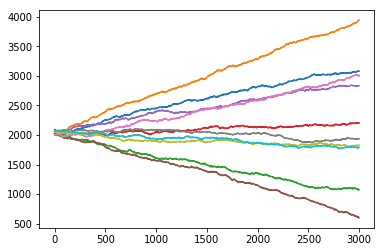

In [25]:
N_samples = 3000
N_states = 4
Mem = 5
N_TS = 10
sigma_Normal = 1

dataset = generate_hmm(n_samples= N_samples,
                       n_states=N_states,
                       n_dim_obs=N_TS,
                       mode_precisions='regain_random',
                       mode_mean = 'Normal',
                       transition_type='fixed',
                       sigma=sigma_Normal,
                       order_hmm = Mem)
p_vec_0 = np.random.uniform(0,100,N_TS)+2000
Data = np.zeros((np.size(dataset['data'],axis=0),N_TS))
for j in range(N_TS):
    plt.plot(p_vec_0[j]+np.cumsum(dataset['data'][:,j]))
    Data[:,j] = p_vec_0[j]+np.cumsum(dataset['data'][:,j])
    
plt.show()

In [ ]:
lam = 40
max_iter = 200

mdl = HHMM_GraphicalLasso(alpha=lam,
                          n_clusters=N_states,
                          verbose=False,
                          max_iter=max_iter,
                          mode='scaled',
                          warm_restart=True,
                          repetitions=1,
                          n_jobs=-1,
                          N_memory_trans = Mem,
                          N_memory_emis=1)
mdl.fit(dataset['data'])

In [ ]:
mdl.precisions_

In [ ]:
label_real_conv, prec_real_conv, gamma_real_conv = conversion_hhmm_results(dataset['states'],
                                                                            dataset['gammas'],
                                                                            dataset['thetas'],
                                                                            N_states,
                                                                            Mem, 
                                                                            real = True)
label_pred_conv, prec_pred_conv,gamma_pred_conv = conversion_hhmm_results(mdl.labels_,
                                                                          mdl.gammas_,
                                                                          mdl.precisions_,
                                                                          N_states, Mem)

In [ ]:
results_recap(label_real_conv, label_pred_conv,prec_real_conv, prec_pred_conv, 
               gamma_real_conv,gamma_pred_conv) 

In [ ]:
plot_results_cluster(Data, label_pred_conv[1:],N_st = N_states,mem = Mem)

In [ ]:
plot_results_cluster(Data, label_real_conv[1:],N_st = N_states,mem = Mem)

In [ ]:
from regain.hmm.hmm_graphical_lasso import HMM_GraphicalLasso 

hmm_gmm = HMM_GraphicalLasso(alpha=lam,
                             max_iter = max_iter,
                             n_clusters=N_states,
                             verbose=False,
                             mode='scaled',
                             warm_restart=True,
                             repetitions=5,
                             n_jobs=-1)
hmm_gmm.fit(dataset['data'])

In [ ]:
results_recap(label_real_conv, hmm_gmm.labels_,prec_real_conv, hmm_gmm.precisions_, 
               gamma_real_conv,hmm_gmm.gammas_) 

In [ ]:
states = [4]
mems = [1,2,3,4,5,6]
dim = 10
mode_prec = ['regain_random']

res_all = {}

In [ ]:
for st in states:
    for mem in mems:
        for mm in mode_prec:


            print('Case: N_states:',st,',TS mem:',mem,',Prec mode:',mm)

            # Generate a dataset
            
            dataset = generate_hmm(n_samples= 3000,
                       n_states=st,
                       n_dim_obs=dim,
                       mode_precisions= mm,
                       mode_mean = 'Normal',
                       transition_type='fixed',
                       sigma=1,
                       order_hmm = mem)

            # CV hmm_gmm 

            hhmm_gmm = HHMM_GraphicalLasso(alpha=1,
                                     n_clusters=st,
                                     verbose=False,
                                     max_iter=100,
                                     mode='scaled',
                                     warm_restart=True,
                                     repetitions=5,
                                     n_jobs=-1,
                                     N_memory_trans = mem,
                                     N_memory_emis=1)

            alpha_list = np.linspace(10,40,5)



            res = cross_validation_higher_order(hhmm_gmm,
                                                dataset['data'],
                                                params={'alpha':alpha_list,
                                                        'n_clusters':[st],
                                                        'N_memory_trans': [mem]},
                                                        n_repetitions=1)
            
                        # define three different models

            #hhmm_gmm
            
            mdl = HHMM_GraphicalLasso(alpha=res[0][0],
                                      n_clusters=st,
                                      verbose=False,
                                      max_iter=200,
                                      mode='scaled',
                                      warm_restart=True,
                                      repetitions=5,
                                      n_jobs=-1,
                                      N_memory_trans = mem,
                                      N_memory_emis=1)
            
            #hmm_gmm
            
            hmm_gmm = HMM_GraphicalLasso(alpha=res[0][0],
                                         n_clusters=st,
                                         verbose=False,
                                         mode='scaled',
                                         warm_restart=True,
                                         repetitions=5,
                                         n_jobs=-1)


            

            # fit and save results
            try :
                mdl.fit(dataset['data'])
            
                
                # conv pred
                label_pred_conv, prec_pred_conv,gamma_pred_conv = conversion_hhmm_results(mdl.labels_,
                                                                                      mdl.gammas_,
                                                                                      mdl.precisions_,
                                                                                      st,
                                                                                      mem)
                #conv real
                
                label_real_conv, prec_real_conv, gamma_real_conv = conversion_hhmm_results(dataset['states'],
                                                                                           dataset['gammas'],
                                                                                           dataset['thetas'],
                                                                                           st,
                                                                                           mem)
                
                
                
                
                
                res_all[(st, mem, mm, 'HHMM_GMM')] = results_recap(label_real_conv,
                                                                   label_pred_conv,
                                                                   prec_real_conv,
                                                                   prec_pred_conv,
                                                                   gamma_real_conv,
                                                                   gamma_pred_conv)
            except:
                print("HHMM-GMM failed")
                
            
            try :
                
                hmm_gmm.fit(dataset['data'])
                res_all[(st, mem, mm, 'HMM_GMM')] = results_recap(label_real_conv,
                                                                      hmm_gmm.labels_,
                                                                      prec_real_conv,
                                                                      hmm_gmm.precisions_,
                                                                      gamma_real_conv,
                                                                      hmm_gmm.gammas_) 
            except:
                print("HMM-GMM failed")



# with open('Cluster_methods_HHMM_HMM.pickle', 'wb') as f:
#     pkl.dump([res_all], f)

In [ ]:
import pickle as pkl

with open('HMMM_results.pkl', 'wb') as f:
    pkl.dump(res_all, f)

In [ ]:
st = 4
mem = 4
mm = 'regain_random'
dim = 10
alpha = 50
# Generate a dataset

dataset = generate_hmm(n_samples= 1000,
           n_states=st,
           n_dim_obs=dim,
           mode_precisions= mm,
           mode_mean = 'Normal',
           transition_type='fixed',
           sigma=1,
           order_hmm = mem)

# CV hmm_gmm 

hhmm_gmm = HHMM_GraphicalLasso(alpha=alpha,
                         n_clusters=st,
                         verbose=False,
                         max_iter=300,
                         mode='scaled',
                         warm_restart=True,
                         repetitions=10,
                         n_jobs=-1,
                         N_memory_trans = mem,
                         N_memory_emis=1)


hhmm_gmm.fit(dataset['data'])            


In [ ]:
# conv pred
label_pred_conv, prec_pred_conv,gamma_pred_conv = conversion_hhmm_results(hhmm_gmm.labels_,
                                                                      hhmm_gmm.gammas_,
                                                                      hhmm_gmm.precisions_,
                                                                      st,
                                                                      mem)

#conv real

label_real_conv, prec_real_conv, gamma_real_conv = conversion_hhmm_results(dataset['states'],
                                                                           dataset['gammas'],
                                                                           dataset['thetas'],
                                                                           st,
                                                                           mem)

results_recap(label_real_conv,
               label_pred_conv,
               prec_real_conv,
               prec_pred_conv,
               gamma_real_conv,
               gamma_pred_conv)

In [ ]:
#hmm_gmm

hmm_gmm = HMM_GraphicalLasso(alpha=45,
                             n_clusters=st,
                             verbose=False,
                             mode='scaled',
                             warm_restart=True,
                             repetitions=5,
                             n_jobs=-1)

hmm_gmm.fit(dataset['data'])

In [ ]:
results_recap(label_real_conv,
              hmm_gmm.labels_,
              prec_real_conv,
              hmm_gmm.precisions_,
              gamma_real_conv,
              hmm_gmm.gammas_)

In [ ]:
# conv pred
label_pred_conv, prec_pred_conv,gamma_pred_conv = conversion_hhmm_results(hhmm_gmm.labels_,
                                                                      hhmm_gmm.gammas_,
                                                                      hhmm_gmm.precisions_,
                                                                      st,
                                                                      mem)
#conv real

label_real_conv, prec_real_conv, gamma_real_conv = conversion_hhmm_results(dataset['states'],
                                                                           dataset['gammas'],
                                                                           dataset['thetas'],
                                                                           st,
                                                                           mem)


res_all[(st, mem, mm, 'HHMM_GMM')] = results_recap(label_real_conv,
                                                   label_pred_conv,
                                                   prec_real_conv,
                                                   prec_pred_conv,
                                                   gamma_real_conv,
                                                   gamma_pred_conv)

                
res_all[(st, mem, mm, 'HMM_GMM')] = results_recap(label_real_conv,
                                                      hmm_gmm.labels_,
                                                      prec_real_conv,
                                                      hmm_gmm.precisions_,
                                                      gamma_real_conv,
                                                      hmm_gmm.gammas_) 


In [ ]:
res_all

In [ ]:
with open('Cluster_methods_HHMM_HMM.pickle', 'wb') as f:
    pkl.dump([res_all], f)